In [36]:
import pandas as pd
import seaborn as sns

In [15]:
# load the data
df = pd.read_csv('CustomerData_LeadGenerator.csv')

<Axes: >

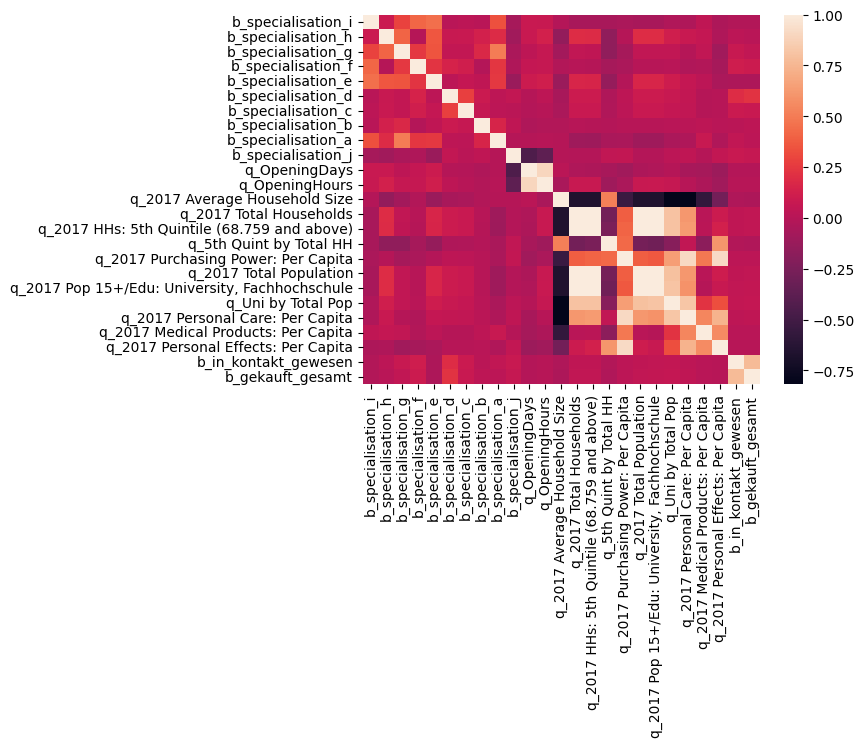

In [37]:
sns.heatmap(df.select_dtypes(exclude='object').corr())

In [32]:
df=df.astype({'q_OpeningHours':float})

In [30]:
import numpy as np 
df['q_OpeningHours']=np.where(df['q_OpeningHours']=='ject',np.nan,df['q_OpeningHours'])

In [38]:
df

,fakeID,b_specialisation_i,b_specialisation_h,b_specialisation_g,b_specialisation_f,b_specialisation_e,b_specialisation_d,b_specialisation_c,b_specialisation_b,b_specialisation_a,...,q_5th Quint by Total HH,q_2017 Purchasing Power: Per Capita,q_2017 Total Population,"q_2017 Pop 15+/Edu: University, Fachhochschule",q_Uni by Total Pop,q_2017 Personal Care: Per Capita,q_2017 Medical Products: Per Capita,q_2017 Personal Effects: Per Capita,b_in_kontakt_gewesen,b_gekauft_gesamt
0,1069_7334,0,0,0,0,0,0,0,0,0,...,0.186735,23730.35,2194057,324656,0.147971,593.19,326.28,235.75,1,1
1,328_2350,0,0,0,1,1,1,0,0,0,...,0.179848,23343.26,1966798,281130,0.142938,588.54,320.36,230.66,1,1
2,865_6285,0,0,0,1,0,1,0,0,0,...,0.184935,23674.18,2149624,320326,0.149015,592.88,325.57,234.82,1,1
3,47_307,0,1,1,0,0,0,0,0,0,...,0.184523,23572.26,2161445,310981,0.143876,590.84,324.06,233.81,1,0
4,342_2513,0,0,0,0,0,1,0,0,0,...,0.189871,23821.63,2302959,334940,0.145439,593.56,327.75,237.41,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3768,54_1517,0,0,0,0,0,0,0,0,0,...,0.203542,23869.52,327760,41107,0.125418,584.76,325.57,238.12,0,0
3769,957_6790,0,0,0,0,0,0,0,0,0,...,0.184899,23677.97,2150320,320715,0.149148,593.07,326.32,235.05,0,0
3770,932_6575,0,0,0,0,0,0,0,0,0,...,0.186292,23721.89,2167556,323263,0.149137,593.23,326.22,235.53,0,0
3771,247_7458,0,0,0,0,0,0,0,0,0,...,0.222034,24711.33,328260,38239,0.116490,593.55,342.68,253.26,0,0


In [ ]:
## define functions for missings
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [42]:
def analyse_cats(df, cat_cols):
    d = pd.DataFrame()
    cl = [];u = [];s =[]; nans =[]
    for c in cat_cols:
        #print("column:" , c ,"--Uniques:" , train[c].unique(), "--Cardinality:", train[c].unique().size)
        cl.append(c); u.append(df[c].unique());s.append(df[c].unique().size);nans.append(df[c].isnull().sum())
        
    d['"feat"'] = cl;d["uniques"] = u; d["cardinality"] = s; d["nans"] = nans
    return d


catanadf = analyse_cats(df, df.columns)

In [39]:
# color the cells based on their value
def color_negative_red(val):
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

# describe the data set
df.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
b_specialisation_i,3773.000000,0.218129,0.413030,0.000000,0.000000,0.000000,0.000000,1.000000
b_specialisation_h,3773.000000,0.224225,0.417126,0.000000,0.000000,0.000000,0.000000,1.000000
b_specialisation_g,3773.000000,0.254704,0.435753,0.000000,0.000000,0.000000,1.000000,1.000000
b_specialisation_f,3773.000000,0.111582,0.314894,0.000000,0.000000,0.000000,0.000000,1.000000
b_specialisation_e,3773.000000,0.285449,0.451688,0.000000,0.000000,0.000000,1.000000,1.000000
b_specialisation_d,3773.000000,0.005566,0.074407,0.000000,0.000000,0.000000,0.000000,1.000000
b_specialisation_c,3773.000000,0.002650,0.051421,0.000000,0.000000,0.000000,0.000000,1.000000
b_specialisation_b,3773.000000,0.020408,0.141411,0.000000,0.000000,0.000000,0.000000,1.000000
b_specialisation_a,3773.000000,0.138616,0.345592,0.000000,0.000000,0.000000,0.000000,1.000000
b_specialisation_j,3773.000000,0.254174,0.435454,0.000000,0.000000,0.000000,1.000000,1.000000


In [43]:
# create the heatmap dataset
df2=train.select_dtypes(exclude='object')

# Compute the correlation matrix
corr = df2.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool_))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=False, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

,"""feat""",uniques,cardinality,nans
0,fakeID,"[1069_7334, 328_2350, 865_6285, 47_307, 342_25...",3773,0
1,b_specialisation_i,"[0, 1]",2,0
2,b_specialisation_h,"[0, 1]",2,0
3,b_specialisation_g,"[0, 1]",2,0
4,b_specialisation_f,"[0, 1]",2,0
5,b_specialisation_e,"[0, 1]",2,0
6,b_specialisation_d,"[0, 1]",2,0
7,b_specialisation_c,"[0, 1]",2,0
8,b_specialisation_b,"[0, 1]",2,0
9,b_specialisation_a,"[0, 1]",2,0


In [ ]:
# plot distribution of 
numeric_cols = train.drop(columns='id').select_dtypes(include='number').columns

n_cols = 4  
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(numeric_cols):

    row = i // n_cols
    col_pos = i % n_cols

    sns.histplot(train[col], ax=axes[row, col_pos], kde=True)
    axes[row, col_pos].set_title(f'Distribution of {col}')
    axes[row, col_pos].set_xlabel(col)
    axes[row, col_pos].set_ylabel('Density')

plt.tight_layout()
plt.show()

C:\Users\captn\AppData\Local\Temp\ipykernel_14548\2710528362.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


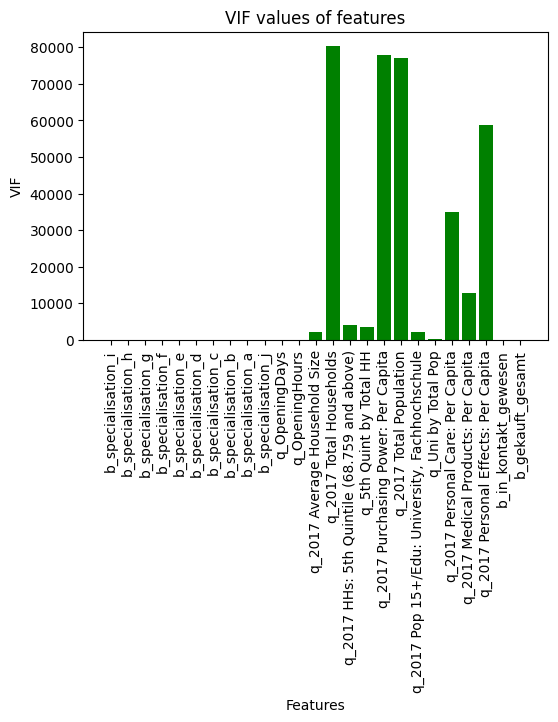

In [50]:
df=df.fillna(0)
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Plot the VIF values
def vif_plot(X):
    vifs = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    feature_orig = list(X.columns)
    plt.figure(figsize=(6, 4))
    plt.bar(feature_orig, vifs, color='green')
    plt.title('VIF values of features')
    plt.xlabel('Features')
    plt.ylabel('VIF')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()  
    
vif_plot(df.select_dtypes(include='number'))

In [45]:
!pip install statsmodels

     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     -------------------- ------------------- 30.7/60.4 kB 1.4 MB/s eta 0:00:01
     ---------------------------------------- 60.4/60.4 kB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.8 MB 2.0 MB/s eta 0:00:05
    --------------------------------------- 0.2/9.8 MB 1.7 MB/s eta 0:00:06
    --------------------------------------- 0.2/9.8 MB 1.8 MB/s eta 0:00:06
   - -------------------------------------- 0.3/9.8 MB 1.6 MB/s eta 0:00:06
   - -------------------------------------- 0.4/9.8 MB 1.8 MB/s eta 0:00:06
   -- ------------------------------------- 0.5/9.8 MB 1.8 MB/s eta 0:00:06
   -- ------------------------------------- 0.6/9.8 MB 1.9 MB/s eta 0:00:05
   -- ------------------------------------- 0.7/9.8 MB 1.9 MB/s eta 0:00:05
   --- ------------------------------------ 0.7/9.8 MB 1.9 MB/s eta 0:00:05
   --- --------

In [48]:
!pip install matplotlib

In [49]:
import matplotlib.pyplot as plt